In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math

import sys

from misc import rcsetup

rcsetup()

sys.path.append("../")

from data import get_powerlaw
from kernels import GaussianKernel, LaplaceKernel, ReluNTK, ReluNNGPKernel
from utils import ensure_numpy

# ReLU NTK / NNGPK

[4.136e-001 7.952e-002 1.061e-002 4.716e-003 7.467e-003 1.869e-002
 6.561e-002 2.957e-001 1.628e+000 1.059e+001 7.944e+001 6.755e+002
 6.419e+003 6.742e+004 7.755e+005 9.695e+006 1.309e+008 1.898e+009
 2.943e+010 4.856e+011 8.499e+012 1.572e+014 3.066e+015 6.286e+016
 1.352e+018 3.041e+019 7.147e+020 1.751e+022 4.466e+023 1.183e+025
 3.255e+026 9.276e+027 2.737e+029 8.347e+030 2.629e+032 8.545e+033
 2.863e+035 9.877e+036 3.506e+038 1.280e+040 4.799e+041 1.848e+043
 7.299e+044 2.956e+046 1.227e+048 5.214e+049 2.268e+051 1.009e+053
 4.592e+054 2.136e+056 1.014e+058 4.920e+059 2.435e+061 1.230e+063
 6.334e+064 3.325e+066 1.779e+068 9.696e+069 5.381e+071 3.040e+073
 1.748e+075 1.023e+077 6.085e+078 3.682e+080 2.264e+082 1.415e+084
 8.986e+085 5.796e+087 3.797e+089 2.525e+091 1.704e+093 1.167e+095
 8.113e+096 5.720e+098 4.090e+100 2.965e+102 2.179e+104 1.624e+106
 1.226e+108 9.378e+109 7.268e+111 5.705e+113 4.536e+115 3.651e+117
 2.976e+119 2.455e+121 2.050e+123 1.732e+125 1.481e+127 1.281e

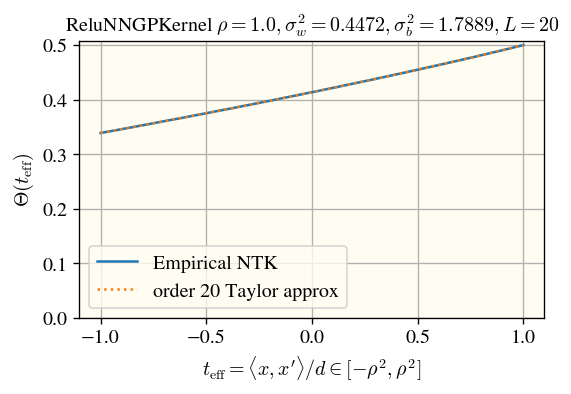

: 

In [ ]:
kerneltype = ReluNNGPKernel
rho = 1.0
sigma_w = 1
sigma_b = 2
w_var = sigma_w**2 / np.sqrt(sigma_b**2 + sigma_w**2)
b_var = sigma_b**2 / np.sqrt(sigma_b**2 + sigma_w**2)
num_points = 26000

data_eigvals = np.array([rho**2])
eval_level_coeff = kerneltype.get_level_coeff_fn(data_eigvals=data_eigvals,
                                                 weight_variance=w_var, bias_variance=b_var)
np.set_printoptions(precision=3, suppress=True)
print(np.array([eval_level_coeff(ell) for ell in range(10)]))

tmin, tmax = -rho**2, rho**2
t_eff = np.linspace(tmin, tmax, num_points)

cosphi = np.clip(t_eff / (rho**2), -1.0, 1.0)
sinphi = np.sqrt(np.maximum(0.0, 1.0 - cosphi**2))
X = np.zeros((num_points, 2))
X[:, 0] = rho * cosphi
X[:, 1] = rho * sinphi
kernel = kerneltype(X, weight_variance=w_var, bias_variance=b_var)
empirical_ntk_theta = ensure_numpy(kernel.K[0, :])[::-1]

# Checking that the level coefficients are correct
 
n_levels = 20
approx = np.zeros_like(t_eff)
for ell in range(n_levels):
    approx += t_eff**ell * eval_level_coeff(ell) / math.factorial(ell)

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(t_eff, empirical_ntk_theta, linestyle="-", label="Empirical NTK")
ax.plot(t_eff, approx, linestyle=":", label=f"order {n_levels} Taylor approx")
ax.set_xlabel(r"$t_{\rm eff}=\langle x,x'\rangle/d \in [-\rho^2,\rho^2]$")
ax.set_ylabel(r"$\Theta(t_{\rm eff})$")
ax.set_title(f"{kerneltype.__name__} $\\rho={{{rho}}}, \\sigma_w^2={{{w_var:.4f}}}, \\sigma_b^2={{{b_var:.4f}}}, L={{{n_levels}}}$")
ax.set_ylim(bottom=min(0.0, empirical_ntk_theta.min()))
ax.legend()
ax.grid(True)
plt.show()


# Gaussian and Laplace kernel

In [ ]:
# SYNTHETIC DATA
################

DATA_DIM = 200
KERNEL_WIDTH = 4
kerneltype = GaussianKernel
data_eigval_exp = 1.2

data_eigvals = get_powerlaw(DATA_DIM, data_eigval_exp, offset=6)

d_eff = 1/(data_eigvals**2).sum().item()
print(f"effective dim = {d_eff:.2f}")

eval_level_coeff = kerneltype.get_level_coeff_fn(data_eigvals=data_eigvals,
                                                 kernel_width=KERNEL_WIDTH)

# Checking that the level coefficients are correct
 
n_levels = 20

z = -1 + 2*torch.rand(size=(10000,))
sum = torch.zeros_like(z)
for ell in range(n_levels):
    sum += z**ell * eval_level_coeff(ell) / math.factorial(ell)

if kerneltype == GaussianKernel:
    ground_truth = torch.exp(-(1-z)/(KERNEL_WIDTH**2))
if kerneltype == LaplaceKernel:
    ground_truth = torch.exp(-torch.sqrt(1-z)/KERNEL_WIDTH)
rel_err = (ground_truth - sum).abs() / ground_truth
print(f"relative error: {100*rel_err.mean().item():.5f}%")

effective dim = 51.60
relative error: 0.00000%
